In [115]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

In [135]:
def drop_vars(df, non_targets):
    
    columns_to_drop = [
        # Those we want to remove for all analyses
        'Date',
        # Those we want to remove for the interpretive model
        'Vodka Sold PC',
        'Gin Sold PC', 'Rum Sold PC', 'Whiskey Sold PC', 'Tequila Sold PC', 'Other Alc Sold PC',
        'Gin Sold PROP','Rum Sold PROP','Whiskey Sold PROP','Tequila Sold PROP','Other Alc Sold PROP','Vodka Sold PROP',

        # Remove targets
        #'Sales Volume PC',
        #'Volume Sold PC',
        #'Bottles Sold PC',

        # Remove linearly dependent columns
        'is_weekend', 'Young Prop', 'LowIncome Prop', 'Other Prop']
    columns_to_drop = columns_to_drop+non_targets

    df = df.drop(columns_to_drop, axis = 1)
    
    return df


def make_dummies(df):

    # get dummies for year 
    year_dummies = pd.get_dummies(df['Year'], drop_first = True)
    year_dummies.columns = ["year_" + str(column) for column in year_dummies.columns]
    df = df.drop(['Year'], axis = 1)

    # get dummies for month
    month_dummies = pd.get_dummies(df['Month'], drop_first = True)
    month_dummies.columns = ["month_" + str(column) for column in month_dummies.columns]
    df = df.drop(['Month'], axis = 1)
    
    # get dummies for county
    county_dummies = pd.get_dummies(df['County'], drop_first = True)
    df = df.drop(['County'], axis = 1)
    
    dow_dummies = pd.get_dummies(df['DOW'], drop_first = True)
    df = df.drop(['DOW'], axis = 1)

    df = pd.concat([df, year_dummies, month_dummies, county_dummies, dow_dummies], axis = 1)
    
    return df


def get_intermediate_matrix(df, target):
    
    target_var = df[target]
    
    df = df.drop([target], axis = 1)
    
    numeric_columns = ['Poverty ', 'Population', 'White Prop', 'Black Prop',
                       'Native American Prop', 'Asian Prop', 'Pacific Prop', 'Two+ Prop',
                       'HighIncome Prop', 'MidIncome Prop', 'Middle-Old Prop','Middle-Young Prop', 'Old Prop']
    
    non_numeric_columns = [column for column in df.columns if column not in numeric_columns]
    
    # standard scale non categorical columns
    ct = make_column_transformer(
            (StandardScaler(), numeric_columns)
            , remainder='passthrough')

    ct_array = ct.fit_transform(df)

    column_order = ['Intercept'] + numeric_columns + non_numeric_columns

    x_mat = np.asmatrix(ct_array) 
    intercept_array = np.ones((x_mat.shape[0], 1))
    x_mat = np.concatenate((intercept_array, x_mat),1)
    response_mat = np.asmatrix(target_var).getT()
    
    matrix_without_target = x_mat
    
    matrix_with_target = np.concatenate((response_mat, x_mat), 1)
    
    return matrix_with_target, matrix_without_target, response_mat, column_order


def get_betas(x_mat, response_mat):
    
    # ols beta estimates
    ols_betas = np.matmul(np.matmul(np.matmul(x_mat.getT(), x_mat).getI(), x_mat.getT()), response_mat)
    
    return ols_betas


def show_beta_summary(betas, column_order):
    
    return pd.DataFrame({'Variable' : column_order, 'Coefficient' : betas.A1}).sort_values(by = 'Coefficient', ascending = False)

In [106]:
def run_cross_val(data, k, penalty="OLS", lam=100):
    # shuffle matrix
    np.random.shuffle(data)
    k_splits = np.array_split(data, k)
    adj_r2_list = []
    for i in range(k):
        # Get train/validation split
        validate = k_splits[i]
        train = np.concatenate([k_splits[j] for j in range(k) if j != i])
        
        y_train = train[:, 0]
        x_train = train[:, 1:]
        
        y_val = validate[:,0]
        x_val = validate[:, 1:]
        # Train the model on the training data
        if penalty == "OLS":
            # ols beta estimates
            betas = np.matmul(np.matmul(np.matmul(x_train.getT(), x_train).getI(), x_train.getT()), y_train)
        elif penalty == "Ridge":
            # make diagonal matrix for lambda
            lambda_mat = np.diag(np.full(x_train.shape[1], lam))
            # ols beta estimates
            betas = np.matmul(np.matmul((np.matmul(x_train.getT(), x_train)+lambda_mat).getI(), x_train.getT()), y_train)
        else:
            raise ValueError("not a recognizable penalty")
        
        # Make predictions on validation data
        y_pred = np.matmul(x_val, betas)
        # rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        adj_r2 = 1-(1-r2)*(x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1])
        adj_r2_list.append(adj_r2)
    
    return adj_r2_list

In [141]:
def roc_df(matrix, lambda_list, k):
    df = {'Lambda': [], 'Avg. Adj-R2': []}
    for l in lambda_list:
        # print('Working on lambda {}'.format(l))
        adj_r2 = np.mean(run_cross_val(matrix, k, "Ridge"))
        df['Lambda'].append(l)
        df['Avg. Adj-R2'].append(adj_r2)
    return pd.DataFrame(df)

In [88]:
df = pd.read_csv("harlech_data_proportions.csv", low_memory = False)

# Predictive Model

## Sales Volume PC

In [183]:
df_sv = drop_vars(df, ['Volume Sold PC', 'Bottles Sold PC'])
df_sv = make_dummies(df_sv)
matrix_with_target, matrix_without_target, response_mat, column_order = get_intermediate_matrix(df_sv, 'Sales Volume PC')

### OLS

In [184]:
np.mean(run_cross_val(matrix_with_target, 5, "OLS"))

0.32726144382846334

### Ridge

In [185]:
np.mean(run_cross_val(matrix_with_target, 5, "Ridge", 100))

0.31720795499382853

<AxesSubplot:xlabel='Lambda'>

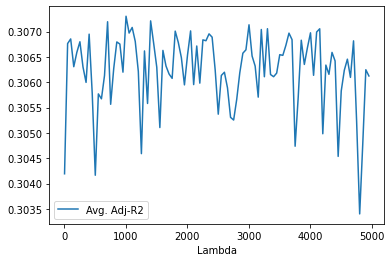

In [186]:
range_test = np.arange(1,5000,50)
roc = roc_df(matrix_with_target, range_test, 2)
roc.plot.line(x='Lambda', y='Avg. Adj-R2')

## Volume Sales PC

In [174]:
df_vs = drop_vars(df, ['Sales Volume PC', 'Bottles Sold PC'])
df_vs = make_dummies(df_vs)
matrix_with_target, matrix_without_target, response_mat, column_order = get_intermediate_matrix(df_vs, 'Volume Sold PC')

### OLS

In [175]:
np.mean(run_cross_val(matrix_with_target, 5, "OLS"))

0.3336969262187053

### Ridge

In [176]:
np.mean(run_cross_val(matrix_with_target, 5, "Ridge", 100))

0.3238541070715466

## Bottle Sales PC

In [178]:
df_bs = drop_vars(df, ['Sales Volume PC', 'Volume Sold PC'])
df_bs = make_dummies(df_bs)
matrix_with_target, matrix_without_target, response_mat, column_order = get_intermediate_matrix(df_bs, 'Bottles Sold PC')

### OLS

In [179]:
np.mean(run_cross_val(matrix_with_target, 5, "OLS"))

0.3229420582867065

### Ridge

In [180]:
np.mean(run_cross_val(matrix_with_target, 5, "Ridge", 100))

0.3137914435308387

In [181]:
betas = get_betas(matrix_without_target,response_mat)

In [182]:
show_beta_summary(betas, column_order)

,Variable,Coefficient
61,DICKINSON,0.216621
48,CERRO GORDO,0.078870
108,POLK,0.070638
60,DES MOINES,0.057460
104,PAGE,0.051227
...,...,...
118,TAYLOR,-0.031930
69,GRUNDY,-0.035195
43,BUTLER,-0.039235
18,year_2017,-0.043183


# Interpretive Model

In [152]:
def make_dummies_int(df):

    # get dummies for month
    month_dummies = pd.get_dummies(df['Month'], drop_first = True)
    month_dummies.columns = ["month_" + str(column) for column in month_dummies.columns]
    df = df.drop(['Month'], axis = 1)
    
    # get dummies for county
    county_dummies = pd.get_dummies(df['County'], drop_first = True)
    df = df.drop(['County'], axis = 1)
    
    dow_dummies = pd.get_dummies(df['DOW'], drop_first = True)
    df = df.drop(['DOW'], axis = 1)

    df = pd.concat([df, month_dummies, county_dummies, dow_dummies], axis = 1)
    
    return df


def get_matrix_int(df, target):
    
    target_var = df[target]
    
    df = df.drop([target], axis = 1)
    
    non_numeric_columns = [column for column in df.columns]

    column_order = ['Intercept'] + non_numeric_columns

    x_mat = np.asmatrix(df) 
    intercept_array = np.ones((x_mat.shape[0], 1))
    x_mat = np.concatenate((intercept_array, x_mat),1)
    response_mat = np.asmatrix(target_var).getT()
    
    matrix_without_target = x_mat
    
    matrix_with_target = np.concatenate((response_mat, x_mat), 1)
    
    return matrix_with_target, matrix_without_target, response_mat, column_order

## Sales Volume PC

In [165]:
int_df_sv = df[['Sales Volume PC', 'Month', 'County', 'DOW']]
int_df_sv = make_dummies_int(int_df_sv)
matrix_with_target, matrix_without_target, response_mat, column_order = get_matrix_int(int_df_sv, 'Sales Volume PC')

### OLS

In [166]:
np.mean(run_cross_val(matrix_with_target, 5, "OLS"))

0.26313715973492613

In [167]:
betas = get_betas(matrix_without_target,response_mat)
show_beta_summary(betas, column_order)

,Variable,Coefficient
40,DICKINSON,3.108836
27,CERRO GORDO,0.957124
24,CARROLL,0.826485
84,PALO ALTO,0.722314
25,CASS,0.707504
...,...,...
48,GRUNDY,-0.379712
46,FREMONT,-0.405852
36,DAVIS,-0.412522
22,BUTLER,-0.453955


## Volume Sales PC

In [168]:
int_df_vs = df[['Volume Sold PC', 'Month', 'County', 'DOW']]
int_df_vs = make_dummies_int(int_df_vs)
matrix_with_target, matrix_without_target, response_mat, column_order = get_matrix_int(int_df_vs, 'Volume Sold PC')

### OLS

In [169]:
np.mean(run_cross_val(matrix_with_target, 5, "OLS"))

0.2779441812212763

In [170]:
betas = get_betas(matrix_without_target,response_mat)
show_beta_summary(betas, column_order)

,Variable,Coefficient
40,DICKINSON,0.219288
27,CERRO GORDO,0.067344
31,CLAY,0.056504
24,CARROLL,0.056287
84,PALO ALTO,0.056263
...,...,...
101,WARREN,-0.028188
36,DAVIS,-0.030456
46,FREMONT,-0.031903
22,BUTLER,-0.032982


## Bottle Sales PC

In [171]:
int_df_bs = df[['Bottles Sold PC', 'Month', 'County', 'DOW']]
int_df_bs = make_dummies_int(int_df_bs)
matrix_with_target, matrix_without_target, response_mat, column_order = get_matrix_int(int_df_bs, 'Bottles Sold PC')

### OLS

In [172]:
np.mean(run_cross_val(matrix_with_target, 5, "OLS"))

0.2535972797109432

In [173]:
betas = get_betas(matrix_without_target,response_mat)
show_beta_summary(betas, column_order)

,Variable,Coefficient
40,DICKINSON,0.207490
27,CERRO GORDO,0.070350
0,Intercept,0.049080
31,CLAY,0.048344
84,PALO ALTO,0.045541
...,...,...
35,DALLAS,-0.029941
48,GRUNDY,-0.030776
36,DAVIS,-0.033325
22,BUTLER,-0.036548
